In [39]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from collections import deque
import matplotlib.pyplot as plt
import glfw
from torchinfo import summary

In [79]:
env = gym.make(
    id='Humanoid-v4',
    terminate_when_unhealthy = True,
    exclude_current_positions_from_observation=False,
    )
print(env.action_space.sample(), len(env.action_space.sample()))
print("\n")
print(env.observation_space.sample(), len(env.observation_space.sample()))

[ 0.34646612  0.3635664  -0.03940015  0.32063693 -0.33002993  0.2276728
  0.14971322  0.17234308 -0.34092498 -0.01047581  0.322303   -0.16857855
  0.25740746 -0.34181812 -0.34394932 -0.09283268  0.31561837] 17


[-0.33641251 -2.44694656  2.26088892 -2.08053164  0.2318244  -0.10291146
  1.11739302 -0.88949918  0.37935643  0.06820152  0.01855046  0.364484
  0.98420439  0.3085797  -0.32341048  0.1329224   0.05185095  1.27732809
 -1.18378383  0.35249981  1.4964967  -0.45236066  0.93171799 -0.50256889
  0.13554346 -0.27559316  0.56635899 -0.57439232  1.08821731  1.58427498
  0.13319563 -0.54790179  0.11185834 -0.5581519   1.34685119  1.6016588
  1.18798521 -0.27959554  0.53971351 -0.26972402 -2.47371499  1.19747939
 -0.56181962  0.60626139 -0.25532676 -0.87678456 -0.06348106  0.56167237
 -0.57511298  0.74981834  0.12124276  1.54076028  0.06565573 -0.18291038
  0.16283129  0.78963378 -0.51200114 -0.13784625  0.15902233 -0.49763915
 -1.03954056 -1.66185999 -0.3642063  -1.67825732  0.38288843 

### Actor

In [103]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output = n_actions
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.mean_fc3 = nn.Linear(self.hidden_size, self.n_output)
        self.log_std_fc3 = nn.Linear(self.hidden_size, self.n_output)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.48)

    def forward(self, x):
        x = x.float()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mean = self.mean_fc3(x)

        log_std = self.log_std_fc3(x)

        return mean, torch.clamp(log_std, -20, 2)
    
    def act(self, state, explore=False):
        mean, log_std = self.forward(state)
        #print(log_std)

        gaussian = Normal(0, 1)
        z = gaussian.sample().to(self.device)
        std = log_std.exp()

        action = torch.tanh(mean + std*z)
        log_prob = Normal(mean, std).log_prob(mean + std*z)

        if explore and np.random.rand() < 7e-1:
            #   m = mean.detach().numpy()
            #   s = std.detach().numpy()
            #   self.noise = OrnsteinUhlenbeckActionNoise(mean=m, sigma=s)
            noise = torch.from_numpy(self.noise())
            #print('\taction: ', action)
            action += noise
            #print('\tnoisy action: ', action)
            #print('\n')
            log_prob += noise

        return action, log_prob
    
actor = Actor(378,64,17, 1e-4)
summary(actor,
        input_size=(1,378),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Actor (Actor)                            [1, 378]             [1, 17]              --                   True
├─Linear (fc1)                           [1, 378]             [1, 64]              24,256               True
├─Linear (fc2)                           [1, 64]              [1, 64]              4,160                True
├─Linear (mean_fc3)                      [1, 64]              [1, 17]              1,105                True
├─Linear (log_std_fc3)                   [1, 64]              [1, 17]              1,105                True
Total params: 30,626
Trainable params: 30,626
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13

### Critic

In [105]:
class Critic(nn.Module) :
    def __init__(self, input_size, hidden_size, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = x.float()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        return self.fc3(x)
critic = Critic(378,64,1, 1e-4)
summary(critic,
        input_size=(1,378),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Critic (Critic)                          [1, 378]             [1, 1]               --                   True
├─Linear (fc1)                           [1, 378]             [1, 64]              24,256               True
├─Linear (fc2)                           [1, 64]              [1, 64]              4,160                True
├─Linear (fc3)                           [1, 64]              [1, 1]               65                   True
Total params: 28,481
Trainable params: 28,481
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.12

### Wrapper

In [8]:
# this wrapper normalize the actions passed to env.step()
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

### A2C

In [106]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic, device=torch.device('cpu')):
        super(ActorCritic, self).__init__()
        self.actor = actor.to(device)
        self.critic = critic.to(device)
        self.device = device

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret
    
    def train(self, gamma=0.9, num_episodes=10000):

        E = NormalizedActions(gym.make(
            id='Humanoid-v4',
            terminate_when_unhealthy = True,
            exclude_current_positions_from_observation=False
            ))
        
        act_losses = deque()
        crt_losses = deque()
        scores = deque()

        for ep in range(num_episodes):

            R = []
            Prob = []
            Values = []
            Delta = []
            state = torch.from_numpy(E.reset()[0])
            done = False
            count = 0

            while not done:
                
                action, prob = self.actor.act(state, explore=True)
                Prob.append(prob)
                #print('Action: ', action)
                #print('Prob: ',prob)

                next_state, reward, term, trunc, _ = E.step(action.detach().numpy())
                next_state = torch.from_numpy(next_state)

                value_state = self.critic.forward(state)
                # print(value_state)
                Values.append(value_state)
                value_next_state = self.critic.forward(next_state)
                
                td_target = reward + gamma*value_next_state
                td_error = td_target - value_state
                #print(td_error)
                Delta.append(td_error)
                done = term or trunc
                count += 1

                forward_old = [state[0], state[24], state[1], state[25]] # x position of torso, X velocity of torso, y position of torso
                forward_next = [next_state[0], next_state[24], next_state[1], state[25]]

                if forward_next[0] > forward_old[0] or forward_next[1] > forward_old[1]:
                    reward += 20 # increase reward for going forward
                flexibility = 5e-2
                if forward_next[2] >= forward_old[2] - flexibility:
                    reward += 50
                if forward_next[3] >= forward_old[3]:
                    reward += 60 
                R.append(reward)

            Prob = torch.stack(Prob).squeeze()
            Values = torch.stack(Values).squeeze()
            Delta = torch.stack(Delta).squeeze()

            act_loss = (- Prob.T @ Delta.detach()).mean()
            crt_loss = self.critic.criterion(Values, Delta)
            # print(act_loss)
            self.actor.optimizer.zero_grad()
            act_loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            self.actor.optimizer.step()

            self.critic.optimizer.zero_grad()
            crt_loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
            self.critic.optimizer.step()

            if ep % 100 == 0:
                print(ep, act_loss, crt_loss, np.mean(R), '\n')

            act_losses.append(act_loss.item())
            crt_losses.append(crt_loss.item())
            scores.append(np.mean(R))

        
        torch.save({
            'model_state_dict': self.state_dict(),
            'actor': act_losses,
            'critic': crt_losses,
            'scores': scores,
            },'humanoid.pt'
        )

        return act_losses, crt_losses, scores

In [107]:
a2c = ActorCritic(actor, critic)

act_losses, crt_losses, scores = a2c.train()

0 tensor(107.1498, grad_fn=<MeanBackward0>) tensor(20.4491, grad_fn=<MseLossBackward0>) 117.23382581216427 

100 tensor(-521.0733, grad_fn=<MeanBackward0>) tensor(128586.0703, grad_fn=<MseLossBackward0>) 126.82472974738667 

200 tensor(330.4026, grad_fn=<MeanBackward0>) tensor(76346.3828, grad_fn=<MseLossBackward0>) 91.81213003315918 

300 tensor(7676.3379, grad_fn=<MeanBackward0>) tensor(376954.3125, grad_fn=<MseLossBackward0>) 115.52145952525541 

400 tensor(188.6522, grad_fn=<MeanBackward0>) tensor(179.9152, grad_fn=<MseLossBackward0>) 134.82222146165753 

500 tensor(2317.3599, grad_fn=<MeanBackward0>) tensor(22850.8574, grad_fn=<MseLossBackward0>) 116.9519026088508 

600 tensor(67.2291, grad_fn=<MeanBackward0>) tensor(33.5262, grad_fn=<MseLossBackward0>) 134.88124909253543 

700 tensor(63.1895, grad_fn=<MeanBackward0>) tensor(11.9972, grad_fn=<MseLossBackward0>) 127.3452201935124 

800 tensor(692.2382, grad_fn=<MeanBackward0>) tensor(19292.4766, grad_fn=<MseLossBackward0>) 92.86322

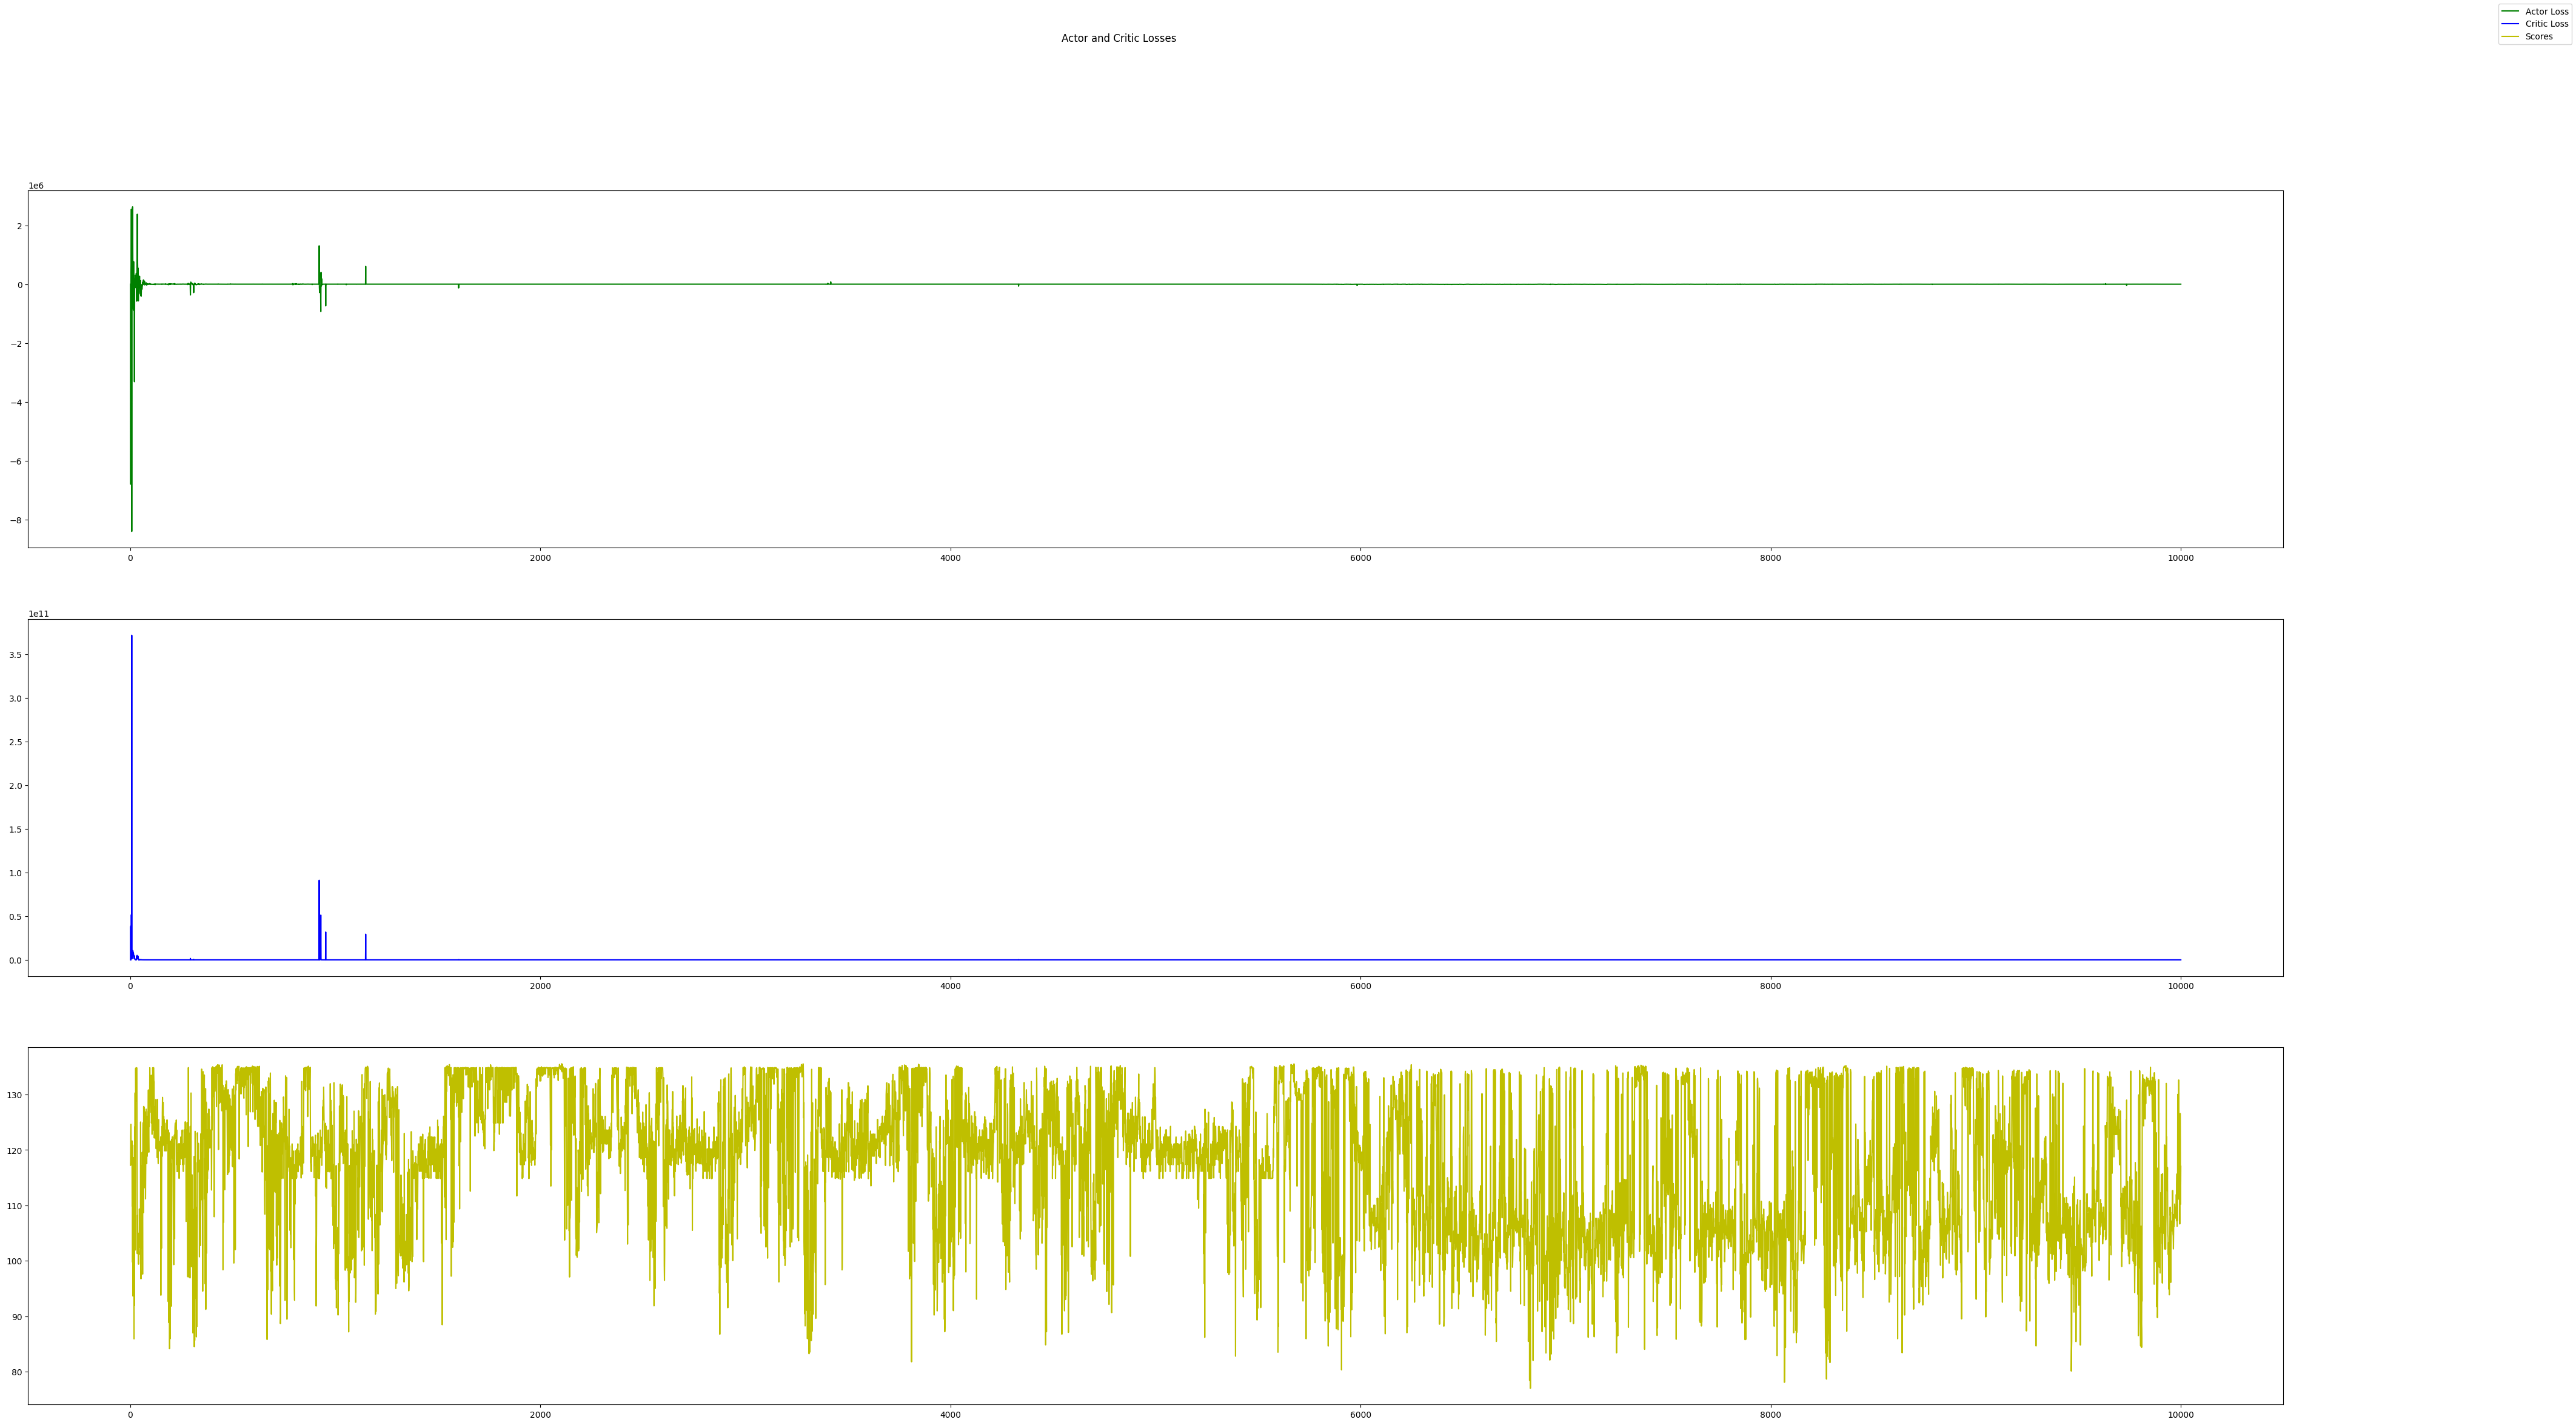

In [131]:
num_episodes = 10000
slice_episodes = num_episodes#200
episodes = np.arange(1, slice_episodes + 1)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Actor and Critic Losses')
act_losses_lim = np.array(act_losses)[:slice_episodes]
crt_losses_lim = np.array(crt_losses)[:slice_episodes]
scores_lim = np.array(scores)[:slice_episodes]
ax1.plot(episodes, act_losses_lim, 'g', label='Actor Loss')
ax2.plot(episodes, crt_losses_lim, 'b', label='Critic Loss')
ax3.plot(episodes, scores_lim, 'y', label='Scores')
fig.legend()
fig.set_figwidth(48)
fig.set_figheight(26)

In [111]:
from gym.wrappers import RecordVideo

In [132]:
def Evaluate(agent, n_eval_episodes, model_name):
    rewards = []
    check = torch.load(model_name+'.pt')
    #agent.load(model_name)
    agent.load_state_dict(check['model_state_dict'])

    val_env = NormalizedActions(gym.make(
            id='Humanoid-v4',
            terminate_when_unhealthy = True,
            exclude_current_positions_from_observation=False,
            render_mode = 'rgb_array',         
        ))
    
    val_env = RecordVideo(val_env, 'video', episode_trigger=lambda x: x==2, video_length=0)

    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        val_env.start_video_recorder()
        done = False
        count = 0
        while not done:
            count += 1
            action, _ = agent.actor.act(torch.from_numpy(obs))
            obs_next, rew, terminated, truncated, _ = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            #val_env.render()
            episode_rewards += rew
            obs = obs_next

        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    val_env.close_video_recorder()
    glfw.terminate()
    val_env.close()


Evaluate(a2c, 1, 'humanoid')

/home/brock/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4
Reward episode 0: 330
Mean Reward:  330.6110967993056
